In [1]:
from random import random
from time import time

from adaptive_zoning import AdaptiveZoneSystem

t = time()

# Create a random data set of n points
n = 50;
origins      = [1 for _ in range(n)]
destinations = [1 for _ in range(n)]
weight       = [1 for _ in range(n)]
points       = [(random(),random()) for _ in range(n)]

# Parameters for the sensitivity to distance, and size of neighbourhoods
beta = 100
nbh_size = 10

# Create the zone system
zone_system = AdaptiveZoneSystem(origins, destinations, weight, points, beta, nbh_size)

print("Calculation took: ", time() - t, " seconds")

Calculation took:  0.015624761581420898  seconds


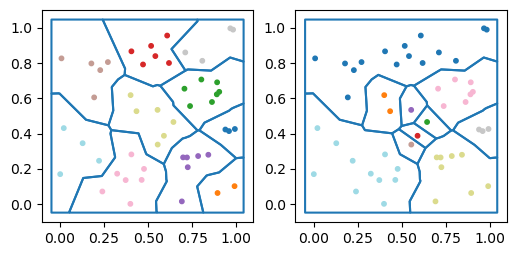

In [2]:
import matplotlib.pyplot as plt

# Plot samples from the zone system. First select aggregateion to a fixed number of zones.
# Second plot a neighbourhood of choice
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
zone_system.plot_n_clusters_voronoi(10, ax[0])
zone_system.plot_neighbourhood_voronoi(3, ax[1])
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import Point, distance

centroid_file = "../Centroids/MSOA_Dec_2011_PWC_in_England_and_Wales.shp"
commuting_file = "../Commuting Data/wu03ew_v2.csv"
residence_column = "Area of residence"
workplace_column = "Area of workplace"
msoa11_columns = "msoa11cd"
count_column_original = "All categories: Method of travel to work"
count_column_target = "commuters"

centroid_data = gpd.read_file(centroid_file)
commuting_data = pd.read_csv(commuting_file)[[residence_column,workplace_column,count_column_original]]

commuting_data = commuting_data.rename(columns={count_column_original: count_column_target})
# ignore commuting outside of England and Wales
commuting_data = commuting_data.loc[commuting_data[workplace_column].isin(centroid_data[msoa11_columns])]

centroid_data.set_index(msoa11_columns, inplace=True)

commuting_data = pd.merge(commuting_data, centroid_data[['geometry']], left_on=residence_column, right_on=msoa11_columns, how='left')
commuting_data = commuting_data.rename(columns={'geometry': 'residence_centroid'})

commuting_data = pd.merge(commuting_data, centroid_data[['geometry']], left_on=workplace_column, right_on=msoa11_columns, how='left')
commuting_data = commuting_data.rename(columns={'geometry': 'workplace_centroid'})

commuting_data['distance'] = commuting_data.apply(lambda row: distance(row['workplace_centroid'], row['residence_centroid']), axis=1)

# Calculate weighted distances
commuting_data['weighted_distance'] = commuting_data['distance'] * commuting_data['commuters']

# Calculate total commuters and total weighted distance
total_commuters = commuting_data['commuters'].sum()
total_weighted_distance = commuting_data['weighted_distance'].sum()

# Calculate average distance
average_distance = total_weighted_distance / total_commuters

workplace_population = commuting_data[['Area of workplace','commuters']].groupby('Area of workplace').sum()
residential_population = commuting_data[['Area of residence','commuters']].groupby('Area of residence').sum()

centroid_data = centroid_data.join(workplace_population)
centroid_data = centroid_data.rename(columns={"commuters": "workplace_population"})
centroid_data = centroid_data.join(residential_population)
centroid_data = centroid_data.rename(columns={"commuters": "residential_population"})

In [ ]:
from time import time
import matplotlib.pyplot as plt

from adaptive_zoning import AdaptiveZoneSystem
from plot_adaptive_zoning import plot_neighbourhood_voronoi, plot_cluster_voronoi

# NOte: in my laptop this takes up to 3 minutes
t = time()

points = [(pt.x,pt.y) for pt in centroid_data.geometry]
leaf_points = points.copy()
pop =  centroid_data['residential_population'].to_list()
emp =  centroid_data['workplace_population'].to_list() 

# Using populations as weights, the paper used area
weight = pop.copy()

beta = 0.11253833770751953 / 1000 # taken from doubly constrained calibration

nbh_size = 72 # reduce to 1% of original OD pairs

zone_system = AdaptiveZoneSystem(pop, emp, weight, points, beta, nbh_size)

print("Calculation took: ", time()-t, " seconds")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
zone_system.plot_n_clusters_voronoi(1018, ax[0])
zone_system.plot_neighbourhood_voronoi(800, ax[1])
plt.show()

In [ ]:
from config_helper import get_key
openroute_api_key = get_key("OpenRouteService","API key","config.ini")

In [ ]:
# initialize results separately, so the nex cell can be run multiple times to collect more data.
results = []

In [ ]:
from math import sqrt
import random

from plot_adaptive_zoning import map_to_n_clusters
from openroute_distance import bng_to_wgs84
from openroute_distance import get_full_distance
from openroute_distance import get_halfway_distance

def map_to_n_clusters_temp(n, zone_tree, reclass = True):
    def get_cluster(index):
        p = zone_tree.get_parent(index)
        if p != None and p < zone_tree.get_size() - n - 1:
            return get_cluster(p)
        return p if not reclass else p - (zone_tree.get_size() - n - 1)

    return [get_cluster(index) for index in range(zone_tree.get_num_leafs())]
    
def straightline_distance(a,b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return sqrt(dx**2 + dy**2)
    
def find_adaptive_neighbour(neighbourhoods, zone_tree, a, b):
    while b not in neighbourhoods[a]:
        b = zone_tree.get_parent(b)
    return b
  
cluster = map_to_n_clusters_temp(1018,zone_tree, False)

points_wgs84 = bng_to_wgs84(points)

# instead of sampling any msoa combinations, sample commuters, this will give better distribution of msoa representative of commuting patterns
sample_size = 5
zones = list(zip(commuting_data['Area of residence'], commuting_data['Area of workplace']))
weights = list(commuting_data['commuters'])
codes = random.choices(zones, weights, k = sample_size)
sample = [(centroid_data.index.get_loc(a),centroid_data.index.get_loc(b)) for a,b in codes]

for a,b in sample:
    a_trad = cluster[a]
    b_trad = cluster[b]

    a_adapt = find_adaptive_neighbour(neighbourhoods, zone_tree, b, a)
    b_adapt = find_adaptive_neighbour(neighbourhoods, zone_tree, a, b)
    
    points_wgs84_a = points_wgs84[a]
    points_wgs84_b = points_wgs84[b]

    points_wgs84_a_trad = points_wgs84[a_trad]
    points_wgs84_b_trad = points_wgs84[b_trad]
    
    points_wgs84_a_adapt = points_wgs84[a_adapt]
    points_wgs84_b_adapt = points_wgs84[b_adapt]

    points_bgn_a = points[a]
    points_bgn_b = points[b]
    
    points_bgn_a_trad = points[a_trad]
    points_bgn_b_trad = points[b_trad]
    
    points_bgn_a_adapt = points[a_adapt]
    points_bgn_b_adapt = points[b_adapt]

    straight_full    = straightline_distance(points_bgn_a       ,points_bgn_b)
    straight_trad    = straightline_distance(points_bgn_a_trad  ,points_bgn_b_trad)
    straight_adapt_1 = straightline_distance(points_bgn_a       ,points_bgn_b_adapt)
    straight_adapt_2 = straightline_distance(points_bgn_a_adapt ,points_bgn_b)

    network_full     = get_full_distance(   points_wgs84_a       ,points_wgs84_b        ,"driving-car", openroute_api_key)['duration']
    network_trad     = get_full_distance(   points_wgs84_a_trad  ,points_wgs84_b_trad   ,"driving-car", openroute_api_key)['duration']
    network_adapt_1  = get_halfway_distance(points_wgs84_a       , points_wgs84_b_adapt ,"driving-car",openroute_api_key,True)['duration']
    network_adapt_2  = get_halfway_distance(points_wgs84_a_adapt , points_wgs84_b       ,"driving-car",openroute_api_key,False)['duration']
   
    if all([v != None for v in [network_full, network_trad, network_adapt_1, network_adapt_2]]):
        
        straight_adapt = (straight_adapt_1 + straight_adapt_2)/2
        network_adapt = network_adapt_1 + network_adapt_2

        # avoid division by zero
        if straight_trad == 0 : straight_trad  = 1
        if straight_adapt == 0: straight_adapt = 1
        
        network_trad_best_guess  = straight_full * network_trad / straight_trad
        network_adapt_best_guess = straight_full * network_adapt/ straight_adapt
        
        results.append((network_full, network_trad_best_guess, network_adapt_best_guess))

print(len(results))

    
    

In [ ]:
import matplotlib.pyplot as plt
#import numpy as np
from sklearn.metrics import r2_score

def plot_aggregation_comparison(data):
    """
    Plots a scatter plot comparing traditional and adaptive aggregation against accurate values,
    when the data is in a list of tuples.

    Args:
        data: List of tuples, where each tuple contains (accurate_value, traditional_value, adaptive_value).
    """

    accurate_values = [item[0] for item in data]
    traditional_values = [item[1] for item in data]
    adaptive_values = [item[2] for item in data]

    plt.figure(figsize=(10, 8))

    # Scatter plot for traditional aggregation
    plt.scatter(accurate_values, traditional_values, label='Traditional Aggregation', marker='o')

    # Scatter plot for adaptive aggregation
    plt.scatter(accurate_values, adaptive_values, label='Adaptive Aggregation', marker='x')

    # Calculate R-squared for traditional aggregation
    r2_traditional = r2_score(accurate_values, traditional_values)
    plt.text(0.05, 0.95, f'R² (Traditional): {r2_traditional:.3f}', transform=plt.gca().transAxes, verticalalignment='top')

    # Calculate R-squared for adaptive aggregation
    r2_adaptive = r2_score(accurate_values, adaptive_values)
    plt.text(0.05, 0.90, f'R² (Adaptive): {r2_adaptive:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
    improvement_factor = (1-r2_traditional)/(1-r2_adaptive)
    plt.text(0.05, 0.85, f'Improvement factor: {improvement_factor:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
  
    # Add the y=x line (accurate prediction line)
    min_val = min(min(accurate_values), min(traditional_values), min(adaptive_values))
    max_val = max(max(accurate_values), max(traditional_values), max(adaptive_values))

    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x (Accurate)')

    # Add labels and title
    plt.xlabel('Accurate Values')
    plt.ylabel('Aggregated Values')
    plt.title('Aggregation Comparison - Travel time (s)')
    #plt.xlim(0,5400)
    #plt.ylim(0,5400)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

plot_aggregation_comparison(results)

In [ ]:
from doubly_constrained_spatial_interaction_model import distance_matrix_from_point
from doubly_constrained_spatial_interaction_model import doubly_constrained
from doubly_constrained_spatial_interaction_model import calibrate_doubly_constrained

points = np.array([(point.x/1000, point.y/1000) for point in centroid_data.geometry])
pop =  centroid_data['residential_population'].to_numpy()
emp =  centroid_data['workplace_population'].to_numpy() 
distance_matrix = distance_matrix_from_points(points)
beta = calibrate_doubly_constrained(pop,emp, distance_matrix, 14.464)
trips, av_distance, a, b = doubly_constrained(pop, emp, distance_matrix, beta,verbose = True)
print(av_distance)